#### <center> Metric Learning. Практика 1

In [160]:
#Загрузим библиотеки
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [31]:
# загрузка данных
data = pd.read_csv('data/marketing_campaign.csv', sep='\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [34]:
# удаление пропусков
#data.describe()
data = data.dropna()
print(f'Количество объектов после удаление пропусков: {data.shape}')

Количество объектов после удаление пропусков: (2216, 29)


In [35]:
# Переведем Dt_Customer в численный, посмотрим на самую раннюю и самую позднюю запись
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
dt_max = data['Dt_Customer'].max()
dt_min = data['Dt_Customer'].min()

print(f'Дата добавления последнего покупателя в базу: {dt_max}')
print(f'Дата добавления первого покупателя в базу: {dt_min}')

Дата добавления последнего покупателя в базу: 2014-12-06 00:00:00
Дата добавления первого покупателя в базу: 2012-01-08 00:00:00


In [38]:
# Добавим признак, показывающий, сколько дней покупатель является клиентом фирмы.
# Для этого вычтем из даты фиксации последнего клиента дату фиксации каждого из клиентов.

data['Customer_For'] = dt_max - data['Dt_Customer']
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [40]:
# Создадим признак возраста покупателя "Age" с учетом того, что последняя запись сделана в 2014 году
data['Age'] = 2014 - data['Year_Birth']

In [50]:
# Создадим признак "Spend", который показывает сколько потратил покупатель на все категории за послдение два года
data['Spend'] = data['MntWines'] + data['MntFruits'] + \
data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

Создадим новый бинарный признак "Living_With" из "Marital_Status", показывающий, живет ли с кем-то покупатель

In [ ]:
data['Marital_Status'].value_counts()
# Married и Together в Partner, остальные - Alone

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [55]:
data['Living_With'] = data['Marital_Status']. replace({'Married':'Partner', 'Together':'Partner',
                                                       'Single':'Alone', 'Divorced':'Alone', 'Widow':'Alone',
                                                       'Absurd':'Alone', 'YOLO':'Alone'})
data['Living_With'].value_counts()

Partner    1430
Alone       786
Name: Living_With, dtype: int64

In [ ]:
# создадим признак "Children", показывающий суммарное число детей в семье
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Children'].value_counts(normalize=True) * 100

Wall time: 0 ns


1    50.406137
0    28.564982
2    18.772563
3     2.256318
Name: Children, dtype: float64

In [73]:
# Создадим признак количество членов семьи "Family_Size"
data['Family_Size'] = data['Living_With'].replace({'Alone':1, 'Partner':2}) + data['Children']
data['Family_Size'].value_counts(normalize=True) * 100

3    39.711191
2    34.160650
4    13.357401
1    11.371841
5     1.398917
Name: Family_Size, dtype: float64

In [74]:
# Создадим бинарный признак "Is_Parent", показывающий, что покупатель является родителем
data['Is_Parent'] = np.where(data.Children > 0, 1, 0)
data['Is_Parent'].value_counts(normalize=True) * 100

1    71.435018
0    28.564982
Name: Is_Parent, dtype: float64

In [75]:
#Уменьшим количество значений признаков в "Education" до 3
data['Education'].value_counts(normalize=True) * 100

Graduation    50.361011
PhD           21.705776
Master        16.471119
2n Cycle       9.025271
Basic          2.436823
Name: Education, dtype: float64

In [76]:
data['Education'] = data['Education'].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate",
                                               "Graduation":"Graduate", "Master":"Postgraduate",
                                               "PhD":"Postgraduate"})
data['Education'].value_counts(normalize=True) * 100

Graduate         50.361011
Postgraduate     38.176895
Undergraduate    11.462094
Name: Education, dtype: float64

In [77]:
    # переименуем признаки покупок
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat",
                              "MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

In [78]:
#Удалим использованные признаки
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   i

In [80]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spend,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,45.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,18.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,37.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,44.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,55.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,121.000000,2525.000000,3.000000,5.000000,1.000000


Гистограммы

Wall time: 0 ns


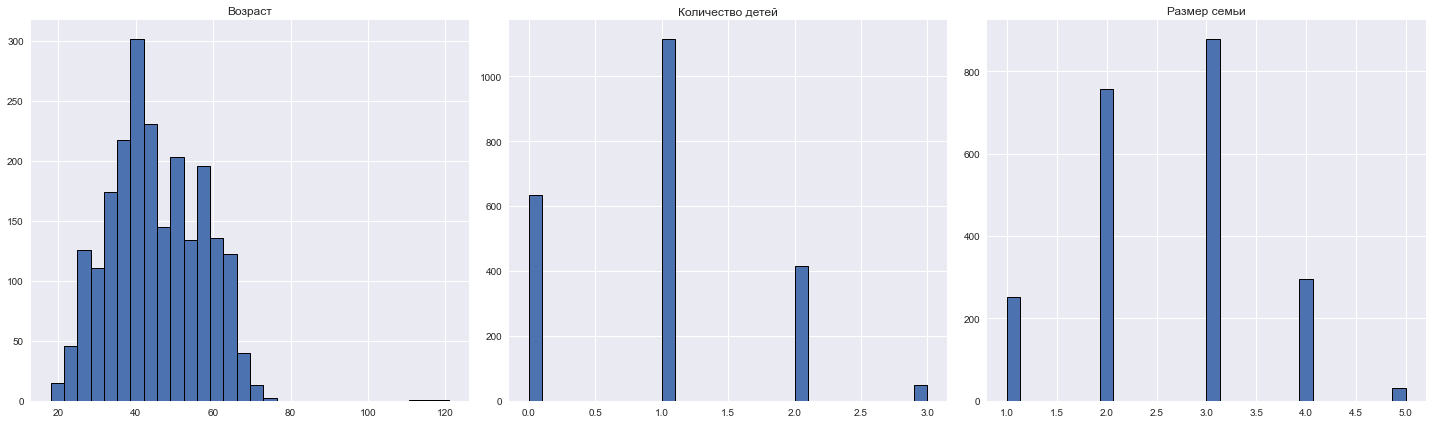

In [166]:
%time
fig, axes = plt.subplots(1, 3, figsize=(20, 6), tight_layout=True)

axes[0].hist(data['Age'], edgecolor='black', bins=30, linewidth=1)
axes[0].set_title('Возраст')
axes[1].hist(data['Children'], edgecolor='black', linewidth=1, bins=30)
axes[1].set_title('Количество детей')
axes[2].hist(data['Family_Size'], edgecolor='black', linewidth=1, bins=30)
axes[2].set_title('Размер семьи')

#plt.tight_layout()
plt.show()